<a href="https://www.kaggle.com/code/threeminutesgameplay/house-prices-advanced-regression-techniques?scriptVersionId=227021854" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/houseprices-new/sample_submission.csv
/kaggle/input/houseprices-new/train.csv
/kaggle/input/houseprices-new/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
from scipy import stats

In [4]:
# Finding the path for required datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/houseprices-new/sample_submission.csv
/kaggle/input/houseprices-new/train.csv
/kaggle/input/houseprices-new/test.csv


In [5]:
# Import data set 
data=pd.read_csv('/kaggle/input/houseprices-new/train.csv')
data_test=pd.read_csv('/kaggle/input/houseprices-new/test.csv')
data_submission=pd.read_csv('/kaggle/input/houseprices-new/sample_submission.csv')

both_data=[data,data_test]

In [6]:
data.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

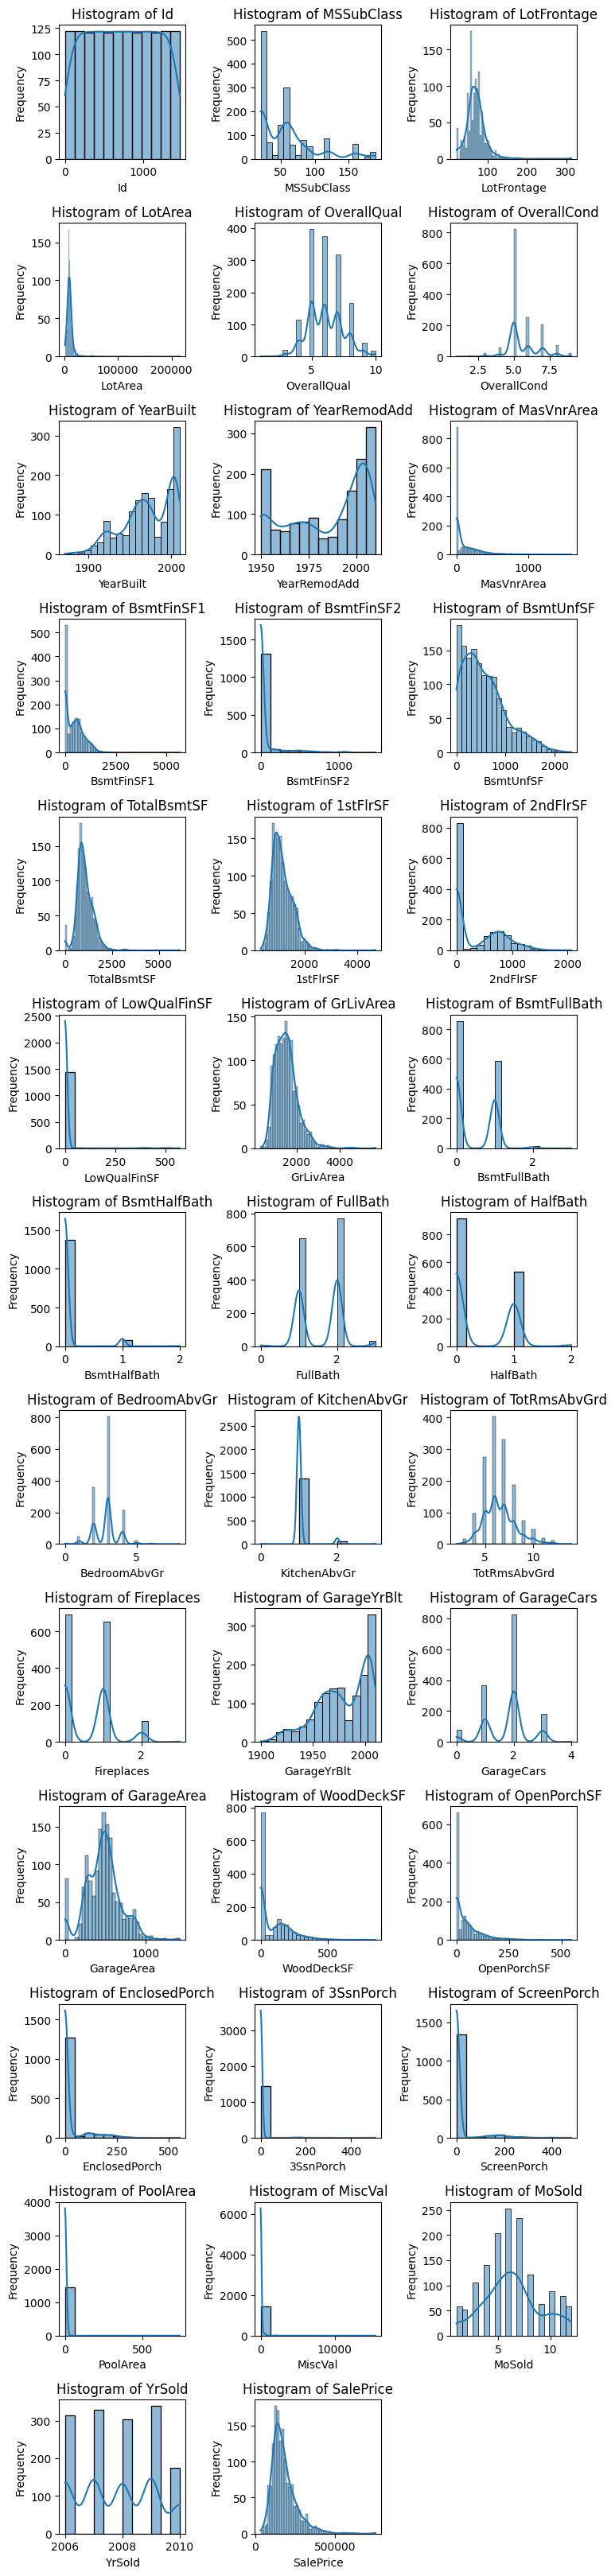

In [8]:
# Checking the distribution of all columns
# Define the number of columns per row
numerical_columns = data.select_dtypes(include=['number']).columns
cols = 3  
num_plots = len(numerical_columns)  # Total number of columns (features)
rows = (num_plots // cols) + (num_plots % cols > 0)  # Ensure enough rows

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
axes = axes.flatten()  # Flatten for easy iteration

# Example: Plot histograms for numerical features
for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], kde=True, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide extra unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

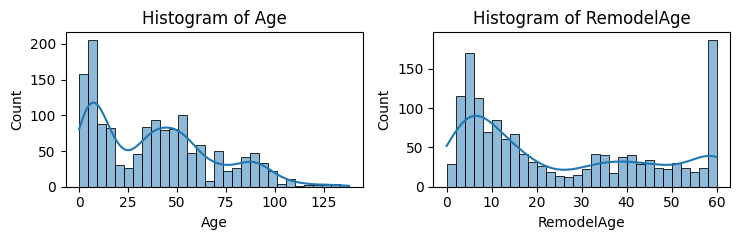

In [9]:
# Transform YearBuilt and YearRemodelAdd into Age and RemodelAge
current_year = data['YrSold'].max()  # Get the latest sale year

# Create new age-related features
for i in both_data: # apply on data & data_test
    i['Age'] = current_year - i['YearBuilt']
    i['RemodelAge'] = current_year - i['YearRemodAdd']

# Plot the new Age & RemodelAge Feature
age_remodel=['Age','RemodelAge']
fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5))  # 1 row, 2 columns

for i,col in enumerate(age_remodel):
    sns.histplot(data=data, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [10]:
# Drop Year columns
for i in both_data: # apply on data & data_test
    i.drop(columns=['YearBuilt', 'YearRemodAdd'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
# Categorical Features with null values
# This Ensures that categorical values are not too diverse to be usefull for prediction
cat_obj_cols = data.select_dtypes(include=['category', 'object'])
null_features_cat = cat_obj_cols.columns[cat_obj_cols.isnull().any()].tolist()

# Convert to DataFrame for better display
pd.DataFrame({
    "Feature": null_features_cat,  # Feature names
    "Value Count": data[null_features_cat].count().values,  # Count of values
    "Missing Count": data[null_features_cat].isnull().sum().values,  # Count of values
    "Unique Count": data[null_features_cat].nunique().values  # Count of unique values
})

,Feature,Value Count,Missing Count,Unique Count
0,Alley,91,1369,2
1,MasVnrType,588,872,3
2,BsmtQual,1423,37,4
3,BsmtCond,1423,37,4
4,BsmtExposure,1422,38,4
5,BsmtFinType1,1423,37,6
6,BsmtFinType2,1422,38,6
7,Electrical,1459,1,5
8,FireplaceQu,770,690,5
9,GarageType,1379,81,6


In [12]:
#Pool QC have 3 different type, with only 7 value
#Misc Feature too anonymous with very low quantity of data to be meaningful
for i in both_data: # apply on data & data_test
    i.drop(columns=['PoolQC','MiscFeature'],inplace=True)

In [13]:
# Check further for Type of Alley Access and Fence Quality
print("Unique values in 'alley':", ', '.join(map(str, data['Alley'].unique())))
print("Unique values in 'fence':", ', '.join(map(str, data['Fence'].unique())))

Unique values in 'alley': nan, Grvl, Pave
Unique values in 'fence': nan, MnPrv, GdWo, GdPrv, MnWw


Fence : Fence Quality
GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
Ordinal relationship for fence

Alley: Type of alley access to property
       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
Ordinal relationship for alley 
This is meaningful even with small data present, feature will be kept and Null Value will be set 0 (lowest order)

In [14]:
# Mapping for fence and alley
# Apply Fence mapping
for i in both_data: # apply on data & data_test
    i['Fence'] = i['Fence'].map({'MnWw': 1, 'MnPrv':2,'GdWo':3,'GdPrv':4})
    i['Fence'].fillna(0, inplace=True)
    i['Alley'] = i['Alley'].map({'Grvl':1,'Pave':2})
    i['Alley'].fillna(0, inplace=True)
print(data['Fence'].unique())
print(data['Alley'].unique())

[0. 2. 3. 4. 1.]
[0. 1. 2.]


In [15]:
#Check for these categorical , wether to OHE or Ordinal According to Price
#apply to data and data_test
for i in both_data: # apply on data & data_test
#1	MasVnrType
#NA , CBlock, BrkCmn, BrkFace , Stone > Ord
    i['MasVnrType'] =i['MasVnrType'].map({'CBlock':1,'BrkCmn':2,'BrkFace':3,'Stone':4})
#4	BsmtExposure	
#NA,No, Mn, Av, Gd > Ord
    i['BsmtExposure']=i['BsmtExposure'].map({'No':1,'Mn':2,'Av':3,'Gd':4})
#7	Electrical << There is missing count 1 for this value, will be filled with mode
#FuseP, FuseF, FuseA, Mix, SBrkr > Ord
    i['Electrical']=i['Electrical'].map({'FuseP':1,'FuseF':2,'FuseA':3,'Mix':4,'SBrkr':4})
#9	GarageType 
#NA, CarPort, Detchd, Basment, Attchd, BuiltIn, 2Types > Ord
    i['GarageType']=data['GarageType'].map({'CarPort':1,'Detchd':2,'Basment':3,'Attchd':4,'BuiltIn':5,'2Types':6})
#10	GarageFinish	
#NA, Unf, RFn, Fin > Ord
    i['GarageFinish']=data['GarageFinish'].map({'Unf':1,'RFn':2,'Fin':3})
#5	BsmtFinType1	
#NA, Unf, LwQ, Rec, BLQ, ALQ, GLQ > Ord
    i['BsmtFinType1']=data['BsmtFinType1'].map({'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
#6	BsmtFinType2	
#NA, Unf, LwQ, Rec, BLQ, ALQ, GLQ > Ord
    i['BsmtFinType2']=data['BsmtFinType2'].map({'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
#2	BsmtQual	
#NA, Po, Fa, TA, Gd, Ex > Ord
#3	BsmtCond	
#NA, Po, Fa, TA, Gd, Ex > Ord
#11	GarageQual	
#NA, Po, Fa, TA, Gd, Ex > Ord
#12	GarageCond	
#NA, Po, Fa, TA, Gd, Ex > Ord
#8	FireplaceQu	
#NA, Po, Fa, TA, Gd, Ex > Ord
    same_col5=['BsmtQual','BsmtCond','GarageQual','GarageCond','FireplaceQu']
    for col in same_col5:
        i[col]=i[col].map({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

# Show only columns with missing values
missing_features = data.isnull().sum()
missing_features = missing_features[missing_features > 0]  # Keep only features with missing values

# Display the features and their missing count
print(missing_features)


LotFrontage     259
MasVnrType      872
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64


In [16]:
# Fill NA with 0 for all of the categorical columns above Except Electrical
remove_items = ['Alley','Electrical','PoolQC','Fence','MiscFeature']
same_null11 = [col for col in null_features_cat if col not in remove_items]
for i in both_data: # apply on data & data_test
    for col in same_null11:
        i[col].fillna(0, inplace=True)
        
# Fill Electrical with mode
    i['Electrical'].fillna(i['Electrical'].mode()[0], inplace=True)
print(i[col].unique())
print(i['Electrical'].unique())

[3. 0. 2. 4. 1. 5.]
[4 3 2 1]


In [17]:
# Handling Null values for numerical columns
num_obj_cols = data.select_dtypes(include=['int64', 'float64'])
null_features_num = num_obj_cols.columns[num_obj_cols.isnull().any()].tolist()

# Convert to DataFrame for better display
pd.DataFrame({
    "Feature": null_features_num,  # Feature names
    "Value Count": data[null_features_num].count().values,  # Count of values
    "Missing Count": data[null_features_num].isnull().sum().values,  # Count of values
    "Unique Count": data[null_features_num].nunique().values  # Count of unique values
})

,Feature,Value Count,Missing Count,Unique Count
0,LotFrontage,1201,259,110
1,MasVnrArea,1452,8,327
2,GarageYrBlt,1379,81,97


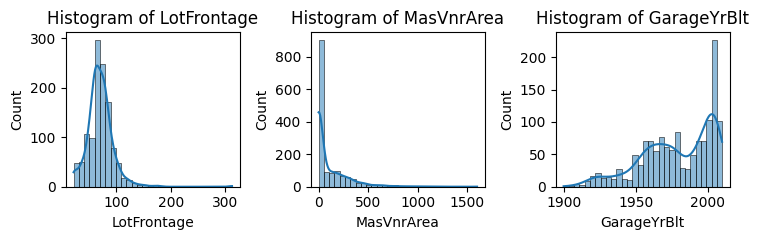

In [18]:
# Lets plot the distribution for these missing values
missing_numerical=['LotFrontage','MasVnrArea','GarageYrBlt']
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))  # 1 row, 3 columns
for i,col in enumerate(missing_numerical):
    sns.histplot(data=data, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [19]:
# LotFrontage is approximately normal, MasVnrArea and GarageYrBlt are skewed
# fillna with respective values
for i in both_data: # apply on data & data_test
    i['LotFrontage'].fillna(i['LotFrontage'].mean(), inplace=True)
    i['MasVnrArea'].fillna(i['MasVnrArea'].median(), inplace=True)
    i['GarageYrBlt'].fillna(i['GarageYrBlt'].median(), inplace=True)

# There will be no more null values
data.isnull().values.any()

False

In [20]:
# Check further for Type of LandContour HouseStyle Exterior2nd SaleCondition since the 
# value in web is incorrect
check_uniqueLHES=['LandContour','HouseStyle','Exterior2nd','SaleCondition']
for i in check_uniqueLHES:
    print(f"Unique values in {i} :", ', '.join(map(str, data[i].unique())))

Unique values in LandContour : Lvl, Bnk, Low, HLS
Unique values in HouseStyle : 2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl, 2.5Unf, 2.5Fin
Unique values in Exterior2nd : VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, Wd Sdng, CmentBd, BrkFace, Stucco, AsbShng, Brk Cmn, ImStucc, AsphShn, Stone, Other, CBlock
Unique values in SaleCondition : Normal, Abnorml, Partial, AdjLand, Alloca, Family


In [21]:
# Get the rest of categorical features
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features

# Identifying ordinal / nominal categorical features & Map Ordinal Features
for i in both_data: # apply on data & data_test
#'Street', Ordinal
# Pave, Grvl      
    i['Street']=i['Street'].map({'Pave':0,'Grvl':1})
#'LandContour', custom ordinal
#Low, HLS 0.9, Bnk 1.1, Lv1
    i['LandContour']=i['LandContour'].map({'Low':0,'HLS':0.9,'Bnk':1.1,'Lvl':2})
#'Utilities', ordinal
#ELO, NoSeWa, NoSewr, AllPub
    i['Utilities']=i['Utilities'].map({'ELO':0,'NoSeWa':1,'NoSewr':2,'AllPub':3})
#'LandSlope', ordinal
# Sev, Mod, Gtl
    i['LandSlope']=i['LandSlope'].map({'Sev':0,'Mod':1,'Gtl':2})
#'HouseStyle', 
# 1Story, 1.5Unf, 1.5Fin , SLvl 2.2, SFoyer 2.2, 2Story, 2.5Unf, 2.5Fin
    i['HouseStyle']=i['HouseStyle'].map({'1Story':0,'1.5Unf':1,'1.5Fin':2,'SLvl':2.2,'SFoyer':2.2,'2Story':3,'2.5Unf':4,'2.5Fin':5})
#'RoofStyle', 
#Flat , Shed, Gable, Gambrel, Hip, Mansard
    i['RoofStyle']=i['RoofStyle'].map({'Flat':0,'Shed':1,'Gable':2,'Gambrel':3,'Hip':4,'Mansard':5})
#'RoofMatl', 
#Roll, Tar&Grv, Membran, CompShg, WdShngl, WdShake, Metal, ClyTile
    i['RoofMatl']=i['RoofMatl'].map({'Roll':0,'Tar&Grv':1,'Membran':2,'CompShg':3,'WdShngl':4,'WdShake':5,'Metal':6,'ClyTile':7})
#'Exterior1st',
#CBlock, Plywood, Other, AsbShng, HdBoard, PreCast, ImStucc, MetalSd, VinylSd, 
#AsphShn, Stucco, Wd Sdng, WdShing, CemntBd, BrkComm, BrkFace, Stone
    i['Exterior1st']=i['Exterior1st'].map({'CBlock':0,'Plywood':1,'Other':2,'AsbShng':3,'HdBoard':4,'PreCast':5,'ImStucc':6,'MetalSd':7,'VinylSd':8,
                                      'AsphShn':9,'Stucco':10,'Wd Sdng':11,'WdShing':12,'CemntBd':13,'BrkComm':14,'BrkFace':15,'Stone':16})
#'Exterior2nd', 
#CBlock, Plywood, Other, AsbShng, HdBoard, PreCast, ImStucc, MetalSd, VinylSd, 
#AsphShn, Stucco, Wd Sdng, Wd Shng, CmentBd, Brk Cmn, BrkFace, Stone
    i['Exterior2nd']=i['Exterior2nd'].map({'CBlock':0,'Plywood':1,'Other':2,'AsbShng':3,'HdBoard':4,'PreCast':5,'ImStucc':6,'MetalSd':7,'VinylSd':8,
                                      'AsphShn':9,'Stucco':10,'Wd Sdng':11,'Wd Shng':12,'CmentBd':13,'Brk Cmn':14,'BrkFace':15,'Stone':16})
#'Foundation', 
#Slab, CBlock, Wood, PConc, BrkTil, Stone
    i['Foundation']=i['Foundation'].map({'Slab':0,'CBlock':1,'Wood':2,'PConc':3,'BrkTil':4,'Stone':5})
#'Heating',
#Grav, Wall, Floor, OthW, GasW, GasA
    i['Heating']=i['Heating'].map({'Grav':0,'Wall':1,'Floor':2,'OthW':3,'GasW':4,'GasA':5})
#'CentralAir', 
#N, Y
    i['CentralAir']=i['CentralAir'].map({'N':0,'Y':1})
#'Functional', 
#Sal, Sev, Maj2, Maj1, Mod, Min2, Min1, Typ
    i['Functional']=i['Functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})
#'PavedDrive',
#N,P,Y
    i['PavedDrive']=i['PavedDrive'].map({'N':0,'P':1,'Y':2})
#'SaleType', 
#COD, Oth, ConLD, ConLI, ConLw, Con, VWD, CWD, WD, New
    i['SaleType']=i['SaleType'].map({'COD':0,'Oth':1,'ConLD':2,'ConLI':3,'ConLw':4,'Con':5,'VWD':6,'CWD':7,'WD':8,'New':9})
#'SaleCondition'
#Abnorml, Family, AdjLand, Alloca, Partial, Normal
    i['SaleCondition']=i['SaleCondition'].map({'Abnorml':0,'Family':1,'AdjLand':2,'Alloca':3,'Partial':4,'Normal':5})
#'HeatingQC', 
#Po, Fa, TA, Gd, Ex
#'KitchenQual', 
#Po, Fa, TA, Gd, Ex
#'ExterQual', 
#Po, Fa, TA, Gd, Ex
#'ExterCond', 
#Po, Fa, TA, Gd, Ex
    same_col4=['HeatingQC','KitchenQual','ExterQual','ExterCond']
    for col in same_col4:
        i[col]=i[col].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
#'MSZoning', Nominal
#'LotShape', nominal
#'LotConfig', nominal
#'Neighborhood', nominal
#'Condition1', nominal
#'Condition2', nom
#'BldgType', nom
nominal_category=['MSZoning','LotShape','LotConfig','Neighborhood','Condition1','Condition2','BldgType']
data = pd.get_dummies(data, columns=nominal_category, drop_first=True, dtype=int)
data_test = pd.get_dummies(data_test, columns=nominal_category, drop_first=True, dtype=int)
data.shape

(1460, 128)

In [22]:
# There is mis information in website that need changes ( wrong feature unique values )
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 128 entries, Id to BldgType_TwnhsE
dtypes: float64(19), int64(109)
memory usage: 1.4 MB


In [24]:
# Checking correlation before transforming features
# Correlation only with SalePrice
correlation_with_saleprice = data.corr()["SalePrice"].sort_values(ascending=False)
pd.set_option("display.max_rows", None)
print(correlation_with_saleprice)

SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
ExterQual               0.682639
KitchenQual             0.659600
GarageCars              0.640409
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
BsmtQual                0.585207
FullBath                0.560664
GarageFinish            0.549247
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
FireplaceQu             0.520438
YearRemodAdd            0.507101
GarageType              0.478885
MasVnrArea              0.472614
Fireplaces              0.466929
GarageYrBlt             0.466754
HeatingQC               0.427649
Neighborhood_NridgHt    0.402149
MasVnrType              0.401151
BsmtFinSF1              0.386420
BsmtExposure            0.374696
LotFrontage             0.334901
Neighborhood_NoRidge    0.330424
WoodDeckSF              0.324413
2ndFlrSF                0.319334
OpenPorchSF             0.315856
BsmtFinTyp

In [25]:
# MODEL BUILDING

# 🔹 Define Features (X) and Target (y)
x = data.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column
y = data['SalePrice']
x= sm.add_constant(x)

# 🔹 Split into Train and Test Sets (80% Train, 20% Test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# 🔹 Print Shapes to Confirm
print(f"x_train Shape: {x_train.shape}, x_test Shape: {x_test.shape}")
print(f"y_train Shape: {y_train.shape}, y_test Shape: {y_test.shape}")

x_train Shape: (1168, 128), x_test Shape: (292, 128)
y_train Shape: (1168,), y_test Shape: (292,)


In [26]:
# Check missing values
missing_features = x_test.isnull().sum()
missing_features = missing_features[missing_features > 0]  # Keep only features with missing values

# Display the features and their missing count
print(missing_features)


Series([], dtype: int64)


In [27]:
# Regression metrics function
def adj_r2(predictors, target, predictions):
    r2 = r2_score(target,predictions)
    n=predictors.shape[0]
    k=predictors.shape[1]
    return 1-((1-r2)*(n-1)/(n-k-1))

def mape_score(targets,predictions):
    return np.mean(np.abs(targets-predictions)/targets)* 100

# performance metric for train and test data
def model_performance_regression(model, predictors, target):
    pred = model.predict(predictors)
    
    r2 = r2_score(target, pred)
    adjr2 = adj_r2(predictors, target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    mae = mean_absolute_error(target, pred)
    mape = mape_score(target, pred)
        
    df_perf=pd.DataFrame ({
        "R2":r2,
        "Adj-R2":adjr2,
        "RMSE":rmse,
        "MAE":mae,
        "MAPE":mape
    }, index=[0]
                         )
    return df_perf

def model_performance_regression_tt(model, x_train, y_train, x_test, y_test):
    # Compute performance for training and test sets
    df_train = model_performance_regression(model, x_train, y_train)
    df_test = model_performance_regression(model, x_test, y_test)
    
    # Combine results into a single DataFrame
    df_perf = pd.concat([df_train, df_test], ignore_index=True)
    
    # Rename index to "Train" and "Test"
    df_perf.index = ["Train", "Test"]
    
    return df_perf

In [28]:
# Linear regression model for benchmark before feature engineering

# Train Linear Regression Model
modelLR_benchmark = LinearRegression()
modelLR_benchmark.fit(x_train, y_train)

LinearRegression()

In [29]:
# Display performance evaluation metrics for train and test
model_performance_regression_tt(modelLR_benchmark, x_train, y_train, x_test, y_test)

,R2,Adj-R2,RMSE,MAE,MAPE
Train,0.883584,0.869242,26631.361647,17193.977678,9.96352
Test,0.845930,0.724943,33148.431658,20629.522739,12.68242


MODEL BENCHMARK
_________________________________________________________________________________
CUSTOM MODEL BUILDING

In [30]:
# Do OLS to get better statistical summary


ols_model = sm.OLS(y_train, x_train).fit()  
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     64.42
Date:                Tue, 11 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:35:01   Log-Likelihood:                -13559.
No. Observations:                1168   AIC:                         2.737e+04
Df Residuals:                    1044   BIC:                         2.799e+04
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0929      0.338      0.275      0.784      -0.571       0.757
Id                      -0.3747      2.064     -0.182      0.856      -4.424       3.675
MSSubClass             -36.8438     92.981     -0.396      0.692    -219.295     145.607
LotFrontage           -180.2327     55.204     -3.265      0.001    -288.557     -71.908
LotArea                  0.5641      0.124      4.557      0.000       0.321       0.807
Street                1.029e+04   1.93e+04      0.532      0.595   -2.76e+04    4.82e+04
Alley                 1960.7442   2812.962      0.697      0.486   -3558.958    7480.447
LandContour           5021.4615   3040.293      1.652      0.099    -944.319     1.1e+04
Utilities             2.192e+04   1.56e+04      1.406      0.160   -8674.346    5.25e+04
LandSlope             1621.8892   4821.318      0.336      0.737   -7838.688    1.11e+04
HouseStyle           -6413.1694   2253.788     -2.846      0.005   -1.08e+04   -1990.700
OverallQual           8429.9195   1293.242      6.518      0.000    5892.269     1.1e+04
OverallCond           5387.7681   1137.535      4.736      0.000    3155.653    7619.883
YearBuilt              253.1766    340.166      0.744      0.457    -414.310     920.663
YearRemodAdd            60.4684    342.950      0.176      0.860    -612.481     733.418
RoofStyle             3194.5784   1155.199      2.765      0.006     927.801    5461.356
RoofMatl             -1.567e+04   3678.229     -4.261      0.000   -2.29e+04   -8454.006
Exterior1st            360.9139    501.891      0.719      0.472    -623.917    1345.745
Exterior2nd            373.6669    488.643      0.765      0.445    -585.167    1332.501
MasVnrType           -1805.4936    860.259     -2.099      0.036   -3493.527    -117.460
MasVnrArea              19.6228      7.603      2.581      0.010       4.705      34.541
ExterQual             1.067e+04   2758.511      3.867      0.000    5253.645    1.61e+04
ExterCond            -4046.5264   2787.767     -1.452      0.147   -9516.791    1423.738
Foundation           -2370.1534   1128.381     -2.100      0.036   -4584.306    -156.000
BsmtQual              6607.0755   2147.127      3.077      0.002    2393.900    1.08e+04
BsmtCond             -6404.0656   2613.520     -2.450      0.014   -1.15e+04   -1275.715
BsmtExposure          7435.2950   1086.921      6.841      0.000    5302.496    9568.094
BsmtFinType1           943.0859    671.441      1.405      0.160    -374.442    2260.614
BsmtFinSF1               4.7689      3.393      1.406      0.160      -1.889      11.427
BsmtFinType2           504.5743   1785.489      0.283      0.778   -2998.982    4008.131
BsmtFinSF2              -2.7266      7.172     -0.380      0.704     -16.799      11.346
BsmtUnfSF               -1.3219      3.202     -0.413    

In [31]:
# Linear Regression Assumption, Independent Residual with Mean 0
np.mean(ols_model.resid)

# It fulfilled, since it is so close to 0

5.297345661060655e-09

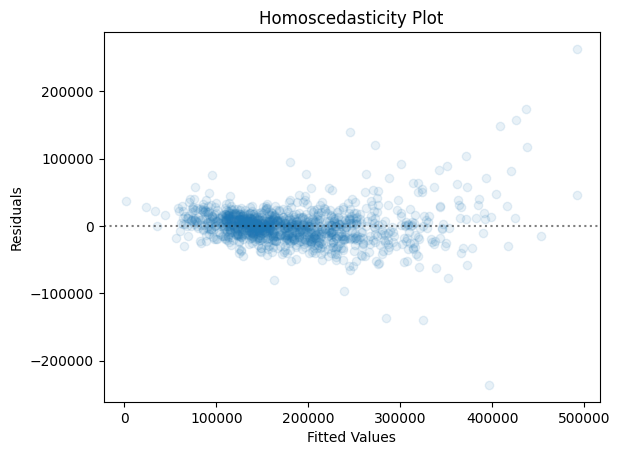

In [32]:
#### Linear Regression Assumption, Homoscedasticity
plt.scatter(ols_model.fittedvalues,ols_model.resid, alpha=0.1)
plt.axhline(0, color='black', alpha=0.5, linestyle='dotted');
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Plot');

In [33]:
homoscedasticity_result = sms.het_goldfeldquandt(y_train, x_train)
homoscedasticity_result[1]

# The result is > 0.05 , the model is homoscedastic

0.4756709619246998

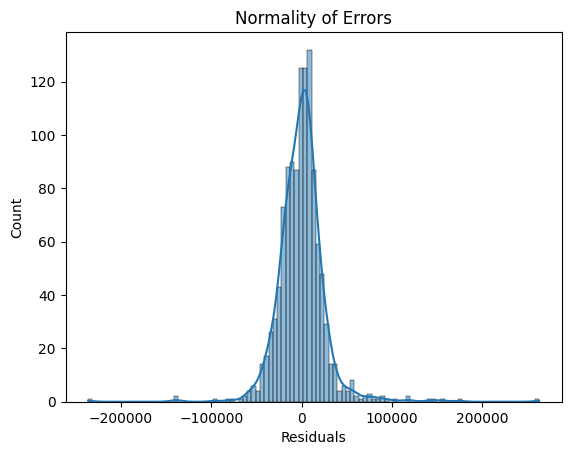

In [34]:
# Assumption 3 Normality of Errors 
sns.histplot(ols_model.resid, kde=True)
plt.xlabel('Residuals')
plt.title('Normality of Errors');

((array([-3.24209521, -2.98025416, -2.83435097, ...,  2.83435097,
          2.98025416,  3.24209521]),
  array([-236110.78762077, -140078.8327325 , -137295.17781794, ...,
          157202.34497856,  174437.06965792,  262978.36612277])),
 (24425.731628682897, 5.302043451254934e-09, 0.9149551909088385))

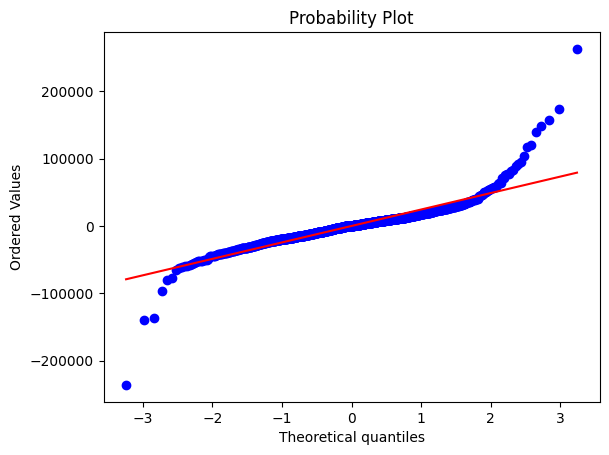

In [35]:
# QQ plot for normality check 2

stats.probplot(ols_model.resid, dist='norm', plot=pylab)

# This confirms that the residual is normally distributed ( majority is in the mean line)

TEST 1 : BUILDING A MODEL WITHOUT FEATURE TRANSFORMATION

In [36]:
# P-value and VIF Filter
# Copy the initial dataset
x_pvcheck = x_train.copy()
x_pvcheck = sm.add_constant(x_pvcheck)
y_pvcheck = y_train.copy()

# Fit the initial OLS model
ols_model_pvcheck = sm.OLS(y_pvcheck, x_pvcheck).fit()

while True:
    p_values = ols_model_pvcheck.pvalues.drop('const', errors='ignore')  # get P, ignore const
    max_p = p_values.max()  # Find the highest p-value
    
    # Remove features with p-value > 0.05
    if max_p > 0.05:  
        feature_to_remove = p_values.idxmax()  # Identify feature to remove
        print(f"Removing {feature_to_remove} (p={max_p:.5f})| R²: {ols_model_pvcheck.rsquared:.5f}")

        # Drop the feature 
        x_pvcheck = x_pvcheck.drop(columns=[feature_to_remove])

        # Refit the model with the updated feature set
        ols_model_pvcheck = sm.OLS(y_pvcheck, x_pvcheck).fit()
        continue  # Restart loop to check p-values again

    # Compute VIF after p-value filtering
    vif_data = pd.DataFrame()
    vif_data["Feature"] = x_pvcheck.columns
    vif_data["VIF"] = [variance_inflation_factor(x_pvcheck.values, i) for i in range(x_pvcheck.shape[1])]

    vif_data = vif_data[vif_data["Feature"] != 'const'] # ignore constant
    max_vif = vif_data["VIF"].max()  # Find the highest VIF

    # Remove features with VIF > 10
    if max_vif > 10:
        feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
        print(f"Removing {feature_to_remove} (VIF={max_vif:.5f})| R²: {ols_model_pvcheck.rsquared:.5f}")

        # Drop the feature 
        x_pvcheck = x_pvcheck.drop(columns=[feature_to_remove])

        # Refit the model with the updated feature set
        ols_model_pvcheck = sm.OLS(y_pvcheck, x_pvcheck).fit()
        continue  # Restart loop to check p-values again

    # Stop if no more features violate p-value and VIF thresholds
    break  

# Final Model Summary
print("\nOLS Model Summary After P-value & VIF filtering:")
print(ols_model_pvcheck.summary())


Removing BldgType_2fmCon (p=0.99474)| R²: 0.88358
Removing GarageYrBlt (p=0.99010)| R²: 0.88358
Removing Neighborhood_BrkSide (p=0.98476)| R²: 0.88358
Removing Heating (p=0.96512)| R²: 0.88358
Removing Neighborhood_MeadowV (p=0.89938)| R²: 0.88358
Removing PavedDrive (p=0.89446)| R²: 0.88358
Removing Condition2_RRAn (p=0.88498)| R²: 0.88358
Removing TotalBsmtSF (p=0.86089)| R²: 0.88358
Removing BsmtUnfSF (p=0.90703)| R²: 0.88358
Removing BsmtFinSF2 (p=0.87283)| R²: 0.88358
Removing Id (p=0.85963)| R²: 0.88357
Removing Age (p=0.85917)| R²: 0.88357
Removing YearRemodAdd (p=0.99301)| R²: 0.88357
Removing BsmtFinType2 (p=0.78727)| R²: 0.88357
Removing MiscVal (p=0.75019)| R²: 0.88356
Removing LandSlope (p=0.72986)| R²: 0.88355
Removing FireplaceQu (p=0.73231)| R²: 0.88354
Removing Neighborhood_Blueste (p=0.67815)| R²: 0.88352
Removing Condition1_RRNe (p=0.67698)| R²: 0.88351
Removing Condition2_RRNn (p=0.65829)| R²: 0.88349
Removing Neighborhood_Somerst (p=0.61227)| R²: 0.88347
Removing Ne

In [37]:
# Convert statsmodels OLS model to scikit-learn compatible format
x_cv = x_pvcheck.copy()  # Use training data for cross-validation
y_cv = y_pvcheck.copy()

# Initialize sklearn's linear regression model (since statsmodels OLS doesn't support CV directly)
lr_model1 = LinearRegression()

# Define K-Fold cross-validation (e.g., 5 folds)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Perform cross-validation using R^2 as the scoring metric
cv_scores = cross_val_score(lr_model1, x_cv, y_cv, cv=kf, scoring='r2')

# Print CV scores and mean R^2
print("Mean R^2 Score :", np.mean(cv_scores))
print("Standard Deviation R^2 Score :", np.std(cv_scores))

Mean R^2 Score : 0.8097877256263691
Standard Deviation R^2 Score : 0.08706995967825945


In [38]:
# Ensure 'data_test' has the same features as x_pvcheck
data_test = sm.add_constant(data_test)
data_test_filtered = data_test[x_pvcheck.columns] 

# Make predictions using the final OLS model
y_pred = ols_model_pvcheck.predict(data_test_filtered)

# Create submission dataframe (assuming 'ID' column exists in data_test)
submission = pd.DataFrame({
    "Id": data_test["Id"],  # Use the ID from original test dataset
    "Prediction": y_pred  # Predicted values
})

# Save submission file
submission.to_csv("submission1.csv", index=False)
submission.shape

(1459, 2)